In [1]:
import torch
import tqdm
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

from hydra import initialize, compose
from hydra.utils import instantiate

from pathlib import Path

from bliss.surveys.dc2 import DC2DataModule
from bliss.catalog import TileCatalog
from bliss.encoder.encoder import Encoder
from bliss.encoder.metrics import DetectionPerformance, SourceTypeFilter

from pytorch_lightning.utilities import move_data_to_device

from case_studies.dc2_cataloging.utils.safe_metric_collection import SafeMetricCollection as MetricCollection
from case_studies.dc2_cataloging.utils.bootstrap_tile_cat import bootstrap_tile_cat
from case_studies.dc2_cataloging.utils.lsst_predictor import LSSTPredictor
from case_studies.dc2_cataloging.utils.notebook_variables import NoteBookVariables

output_dir = Path("./detection_bootstrap_output/")
output_dir.mkdir(parents=True, exist_ok=True)

# change this model path according to your training setting
model_path = "../../../bliss_output/DC2_cataloging_exp_07/exp_07-11-2/checkpoints/best_encoder.ckpt"
lsst_root_dir = "/data/scratch/dc2_nfs/"

device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

plt.rcParams.update({"font.size": NoteBookVariables.font_size})

In [2]:
with initialize(config_path=".", version_base=None):
    notebook_cfg = compose("notebook_config")

In [3]:
tile_slen = notebook_cfg.surveys.dc2.tile_slen
max_sources_per_tile = notebook_cfg.surveys.dc2.max_sources_per_tile
r_band_min_flux = notebook_cfg.encoder.min_flux_for_metrics

dc2: DC2DataModule = instantiate(notebook_cfg.surveys.dc2)
dc2.setup(stage="validate")
dc2_val_dataloader = dc2.val_dataloader()

bliss_encoder: Encoder = instantiate(notebook_cfg.encoder).to(device=device)
pretrained_weights = torch.load(model_path, map_location=device)["state_dict"]
bliss_encoder.load_state_dict(pretrained_weights)
bliss_encoder = bliss_encoder.eval()

In [4]:
lsst_predictor = LSSTPredictor(lsst_root_dir, r_band_min_flux, tile_slen, max_sources_per_tile)

In [5]:
def move_tile_cat_to_device(ori_tile_cat: TileCatalog, device):
    tile_dict = move_data_to_device(ori_tile_cat.data, device=device)
    return TileCatalog(ori_tile_cat.tile_slen, tile_dict)

In [6]:
bliss_tile_cat_list = []
lsst_tile_cat_list = []
target_tile_cat_list = []
for batch in tqdm.tqdm(dc2_val_dataloader):
    batch_on_device = move_data_to_device(batch, device=device)
    target_tile_cat = TileCatalog(tile_slen, batch["tile_catalog"])
    target_tile_cat = target_tile_cat.filter_by_flux(
            min_flux=r_band_min_flux,
            band=2,  # default is r band
        )
    with torch.no_grad():
        bliss_tile_cat = bliss_encoder.sample(batch_on_device, use_mode=True)
        bliss_tile_cat = bliss_tile_cat.filter_by_flux(
            min_flux=r_band_min_flux,
            band=2,
        )
    target_tile_cat_list.append(move_tile_cat_to_device(target_tile_cat, device="cpu"))
    bliss_tile_cat_list.append(move_tile_cat_to_device(bliss_tile_cat, device="cpu"))
    
    wcs_header_str_list = batch["wcs_header_str"]
    image_lim = batch["images"].shape[2]
    height_index_list = batch["image_height_index"].tolist()
    width_index_list = batch["image_width_index"].tolist()
    lsst_tile_cat = lsst_predictor.predict(wcs_header_str_list, 
                                                image_lim, 
                                                height_index_list, 
                                                width_index_list)
    lsst_tile_cat_list.append(lsst_tile_cat)

100%|██████████| 391/391 [21:44<00:00,  3.34s/it]


In [7]:
# bootstrap
matcher = instantiate(notebook_cfg.encoder.matcher)
mag_bin_cutoffs = [23.9, 24.1, 24.5, 24.9, 25.6]
bliss_metrics = MetricCollection({
    "detection_performance": DetectionPerformance(bin_cutoffs=mag_bin_cutoffs,
                                                  bin_type="Mag"),
    "detection_performance_star": DetectionPerformance(bin_cutoffs=mag_bin_cutoffs,
                                                       bin_type="Mag",
                                                       filter_list=[SourceTypeFilter(filter_type="star")]),
    "detection_performance_galaxy": DetectionPerformance(bin_cutoffs=mag_bin_cutoffs,
                                                         bin_type="Mag",
                                                         filter_list=[SourceTypeFilter(filter_type="galaxy")]),
})
lsst_metrics = bliss_metrics.clone()

bliss_metrics_internal_states = {}
lsst_metrics_internal_states = {}

bliss_metrics_results = {}
lsst_metrics_results = {}

epochs_num = 10
for epoch in range(epochs_num):
    print(f"Epoch: {epoch}")
    seed = random.randint(1e4, 1e5 - 1)
    for bliss_tile_cat, lsst_tile_cat, target_tile_cat in tqdm.tqdm(zip(bliss_tile_cat_list, 
                                                                        lsst_tile_cat_list, 
                                                                        target_tile_cat_list)):
        bliss_full_cat = bootstrap_tile_cat(bliss_tile_cat, seed=seed).to_full_catalog()
        lsst_full_cat = bootstrap_tile_cat(lsst_tile_cat, seed=seed).to_full_catalog()
        target_full_cat = bootstrap_tile_cat(target_tile_cat, seed=seed).to_full_catalog()

        bliss_matching = matcher.match_catalogs(target_full_cat, bliss_full_cat)
        bliss_metrics.update(target_full_cat, bliss_full_cat, bliss_matching)

        lsst_matching = matcher.match_catalogs(target_full_cat, lsst_full_cat)
        lsst_metrics.update(target_full_cat, lsst_full_cat, lsst_matching)

    for k, v in bliss_metrics.items():
        internal_states = v.get_internal_states()
        for k_state, v_state in internal_states.items():
            if k_state not in bliss_metrics_internal_states:
                bliss_metrics_internal_states[k_state] = []
            bliss_metrics_internal_states[k_state].append(v_state)

        results = v.get_results_on_per_bin()
        for k_result, v_result in results.items():
            if k_result not in bliss_metrics_results:
                bliss_metrics_results[k_result] = []
            bliss_metrics_results[k_result].append(v_result)

    for k, v in lsst_metrics.items():
        internal_states = v.get_internal_states()
        for k_state, v_state in internal_states.items():
            if k_state not in lsst_metrics_internal_states:
                lsst_metrics_internal_states[k_state] = []
            lsst_metrics_internal_states[k_state].append(v_state)

        results = v.get_results_on_per_bin()
        for k_result, v_result in results.items():
            if k_result not in lsst_metrics_results:
                lsst_metrics_results[k_result] = []
            lsst_metrics_results[k_result].append(v_result)

    bliss_metrics.reset()
    lsst_metrics.reset()

bliss_metrics_internal_states = {k: torch.stack(v) for k, v in bliss_metrics_internal_states.items()}
lsst_metrics_internal_states = {k: torch.stack(v) for k, v in lsst_metrics_internal_states.items()}

Epoch: 0


391it [02:18,  2.82it/s]


Epoch: 1


391it [02:11,  2.98it/s]


Epoch: 2


391it [02:05,  3.12it/s]


Epoch: 3


391it [01:58,  3.29it/s]


Epoch: 4


391it [02:16,  2.86it/s]


Epoch: 5


391it [02:13,  2.92it/s]


Epoch: 6


391it [02:13,  2.92it/s]


Epoch: 7


391it [02:12,  2.95it/s]


Epoch: 8


391it [02:12,  2.96it/s]


Epoch: 9


391it [02:15,  2.88it/s]


In [8]:
def plot_with_error_bars(n_true_sources_1, n_est_sources_1, n_true_matches_1, n_est_matches_1,
                         n_true_sources_2, n_est_sources_2, n_true_matches_2, n_est_matches_2,
                         bin_cutoffs,
                         postfix_str, 
                         model_name_1, model_name_2):
    quantile_points = torch.tensor([0.05, 0.5, 0.95])

    recall_list_1 = (n_true_matches_1 / n_true_sources_1).nan_to_num(0)
    precision_list_1 = (n_est_matches_1 / n_est_sources_1).nan_to_num(0)
    f1_list_1 = (2 * precision_list_1 * recall_list_1 / (precision_list_1 + recall_list_1)).nan_to_num(0)

    recall_list_2 = (n_true_matches_2 / n_true_sources_2).nan_to_num(0)
    precision_list_2 = (n_est_matches_2 / n_est_sources_2).nan_to_num(0)
    f1_list_2 = (2 * precision_list_2 * recall_list_2 / (precision_list_2 + recall_list_2)).nan_to_num(0)

    recall_matrix_1 = recall_list_1.quantile(q=quantile_points, dim=0)
    precision_matrix_1 = precision_list_1.quantile(q=quantile_points, dim=0)
    f1_matrix_1 = f1_list_1.quantile(q=quantile_points, dim=0)

    recall_matrix_2 = recall_list_2.quantile(q=quantile_points, dim=0)
    precision_matrix_2 = precision_list_2.quantile(q=quantile_points, dim=0)
    f1_matrix_2 = f1_list_2.quantile(q=quantile_points, dim=0)

    xlabels = (
        ["[< " + str(bin_cutoffs[0]) + "]"]
        + [f"[{bin_cutoffs[i]}, {bin_cutoffs[i + 1]}]" for i in range(len(bin_cutoffs) - 1)]
        + ["> " + str(bin_cutoffs[-1])]
    )
    x = list(range(len(xlabels)))
    bar_width = 0.4

    sns.set_theme(style="whitegrid")
    color_list = plt.rcParams["axes.prop_cycle"].by_key()["color"][0:6]
    graph_tag = f"({postfix_str[1:]})" if postfix_str else ""

    # recall
    recall_fig, recall_axes = plt.subplots(
        2, 1, figsize=NoteBookVariables.figsize, gridspec_kw={"height_ratios": [1, 2]}, sharex="col"
    )

    recall_axes[1].plot(
        x,
        recall_matrix_1[1, :].tolist(),
        "-o",
        color=color_list[0],
        label=f"{model_name_1} {graph_tag}",
    )
    recall_axes[1].fill_between(
        x,
        recall_matrix_1[0, :].tolist(),
        recall_matrix_1[2, :].tolist(),
        color=color_list[0],
        alpha=0.5,
    )
    recall_axes[1].plot(
        x,
        recall_matrix_2[1, :].tolist(),
        "-o",
        color=color_list[1],
        label=f"{model_name_2} {graph_tag}",
    )
    recall_axes[1].fill_between(
        x,
        recall_matrix_2[0, :].tolist(),
        recall_matrix_2[2, :].tolist(),
        color=color_list[1],
        alpha=0.5,
    )

    recall_axes[1].set_xlabel("Magnitudes")
    recall_axes[1].set_xticks(range(len(xlabels)))
    recall_axes[1].set_xticklabels(xlabels, rotation=45)
    recall_axes[1].set_ylim(bottom=0.5, top=1.0)
    recall_axes[1].set_ylabel("Recall")
    recall_axes[1].legend()

    recall_axes[0].bar(
        x - 0.5 * bar_width,
        n_true_sources_1.mean(dim=0).tolist(),
        bar_width,
        label=f"ground truth {graph_tag}",
        color=color_list[2],
    )
   
    count_max = n_true_sources_1.max().item()
    count_ticks = np.round(np.linspace(0, count_max, 5), -3)
    recall_axes[0].set_yticks(count_ticks)
    recall_axes[0].set_ylabel("# of objects")
    recall_axes[0].legend()
  
    # precision
    precision_fig, precision_axes = plt.subplots(
        2, 1, figsize=NoteBookVariables.figsize, gridspec_kw={"height_ratios": [1, 2]}, sharex="col"
    )

    precision_axes[1].plot(
        x,
        precision_matrix_1[1, :].tolist(),
        "-o",
        color=color_list[0],
        label=f"{model_name_1} {graph_tag}",
    )
    precision_axes[1].fill_between(
        x,
        precision_matrix_1[0, :].tolist(),
        precision_matrix_1[2, :].tolist(),
        color=color_list[0],
        alpha=0.5,
    )
    precision_axes[1].plot(
        x,
        precision_matrix_2[1, :].tolist(),
        "-o",
        color=color_list[1],
        label=f"{model_name_2} {graph_tag}",
    )
    precision_axes[1].fill_between(
        x,
        precision_matrix_2[0, :].tolist(),
        precision_matrix_2[2, :].tolist(),
        color=color_list[1],
        alpha=0.5,
    )

    precision_axes[1].set_xlabel("Magnitudes")
    precision_axes[1].set_xticks(range(len(xlabels)))
    precision_axes[1].set_xticklabels(xlabels, rotation=45)
    precision_axes[1].set_ylim(bottom=0.5, top=1.0)
    precision_axes[1].set_ylabel("Precision")
    precision_axes[1].legend()

    precision_axes[0].bar(
        x - bar_width,
        n_est_sources_1.mean(dim=0).tolist(),
        bar_width,
        label=f"{model_name_1}{graph_tag}",
        color=color_list[2],
    )
    precision_axes[0].bar(
        x,
        n_est_sources_2.mean(dim=0).tolist(),
        bar_width,
        label=f"{model_name_2}{graph_tag}",
        where="mid",
        color=color_list[3],
    )
    count_max = n_true_sources_1.max().item()
    count_ticks = np.round(np.linspace(0, count_max, 5), -3)
    precision_axes[0].set_yticks(count_ticks)
    precision_axes[0].set_ylabel("# of detections")
    precision_axes[0].legend()

    precision_fig.tight_layout()

    # f1
    f1_fig, f1_axes = plt.subplots(
        2, 1, figsize=NoteBookVariables.figsize, gridspec_kw={"height_ratios": [1, 2]}, sharex="col"
    )

    f1_axes[1].plot(
        x,
        f1_matrix_1[1, :].tolist(),
        "-o",
        color=color_list[0],
        label=f"{model_name_1} {graph_tag}",
    )
    f1_axes[1].fill_between(
        x,
        f1_matrix_1[0, :].tolist(),
        f1_matrix_1[2, :].tolist(),
        color=color_list[0],
        alpha=0.5,
    )
    f1_axes[1].plot(
        x,
        f1_matrix_2[1, :].tolist(),
        "-o",
        color=color_list[1],
        label=f"{model_name_2} {graph_tag}",
    )
    f1_axes[1].fill_between(
        x,
        f1_matrix_2[0, :].tolist(),
        f1_matrix_2[2, :].tolist(),
        color=color_list[1],
        alpha=0.5,
    )

    f1_axes[1].set_xlabel("Magnitudes")
    f1_axes[1].set_xticks(range(len(xlabels)))
    f1_axes[1].set_xticklabels(xlabels, rotation=45)
    f1_axes[1].set_ylim(bottom=0.5, top=1.0)
    f1_axes[1].set_ylabel("F1")
    f1_axes[1].legend()

    f1_axes[0].step(
        x - bar_width,
        n_est_sources_1.mean(dim=0).tolist(),
        bar_width,
        label=f"# of {model_name_1} detections {graph_tag}",
        color=color_list[2],
    )
    f1_axes[0].step(
        x,
        n_est_sources_2.mean(dim=0).tolist(),
        bar_width,
        label=f"# of {model_name_2} detections {graph_tag}",
        where="mid",
        color=color_list[3],
    )
   
    count_max = n_true_sources_1.max().item()
    count_ticks = np.round(np.linspace(0, count_max, 5), -3)
    f1_axes[0].set_yticks(count_ticks)
    f1_axes[0].set_ylabel("# of objects")
    f1_axes[0].legend()

    f1_fig.tight_layout()

    return recall_fig, precision_fig, f1_fig

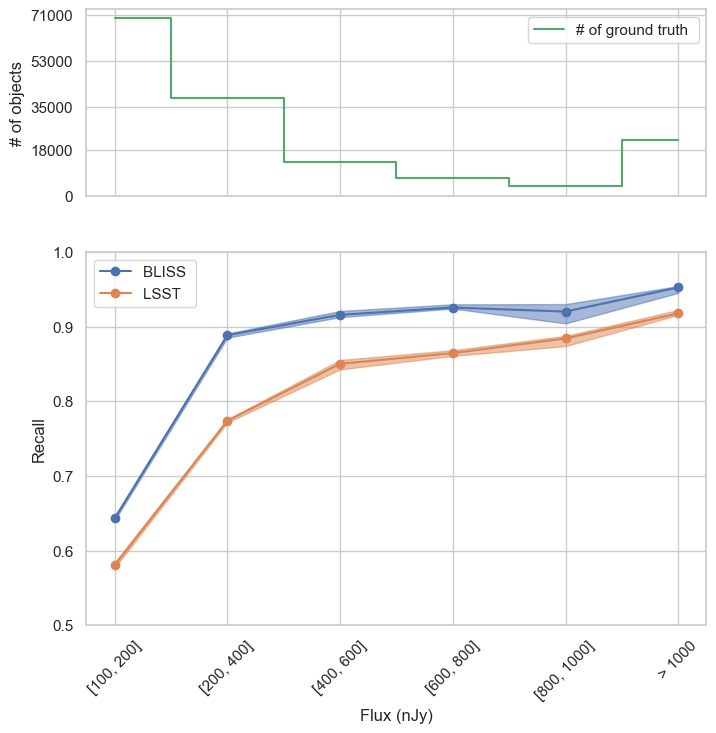

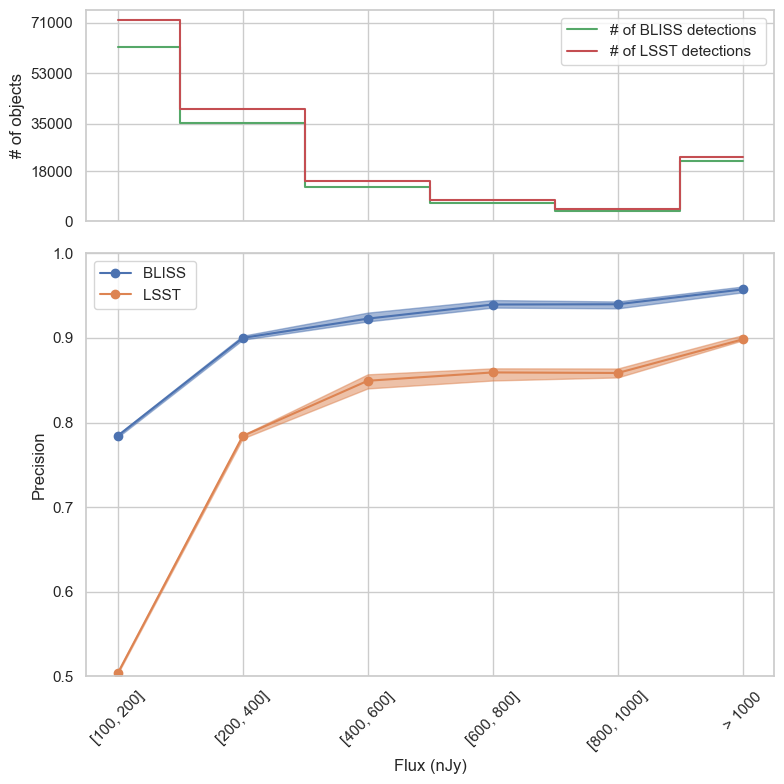

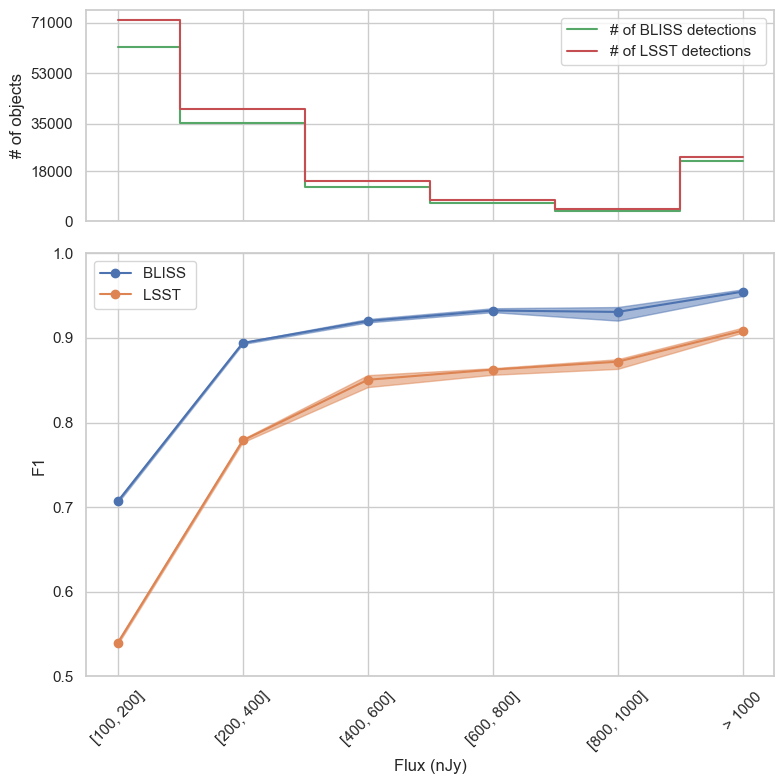

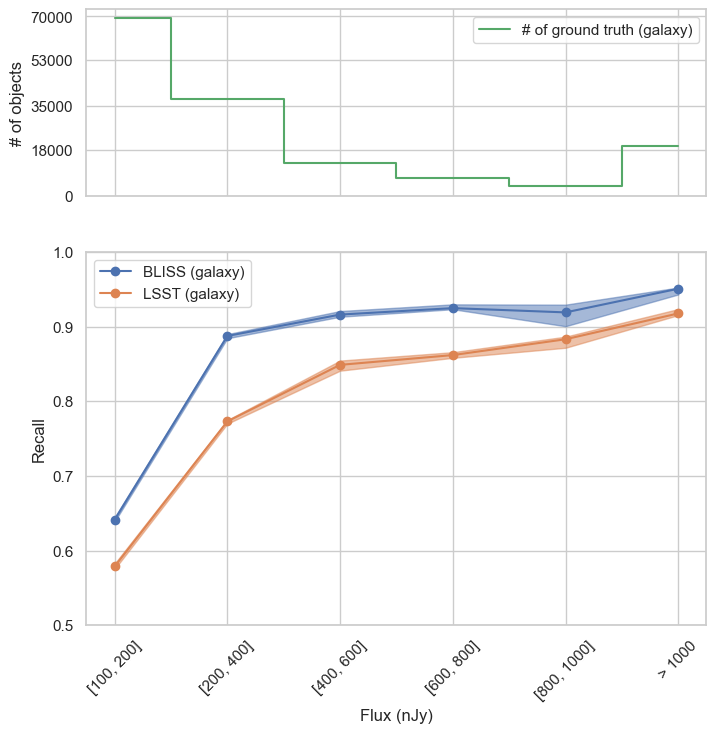

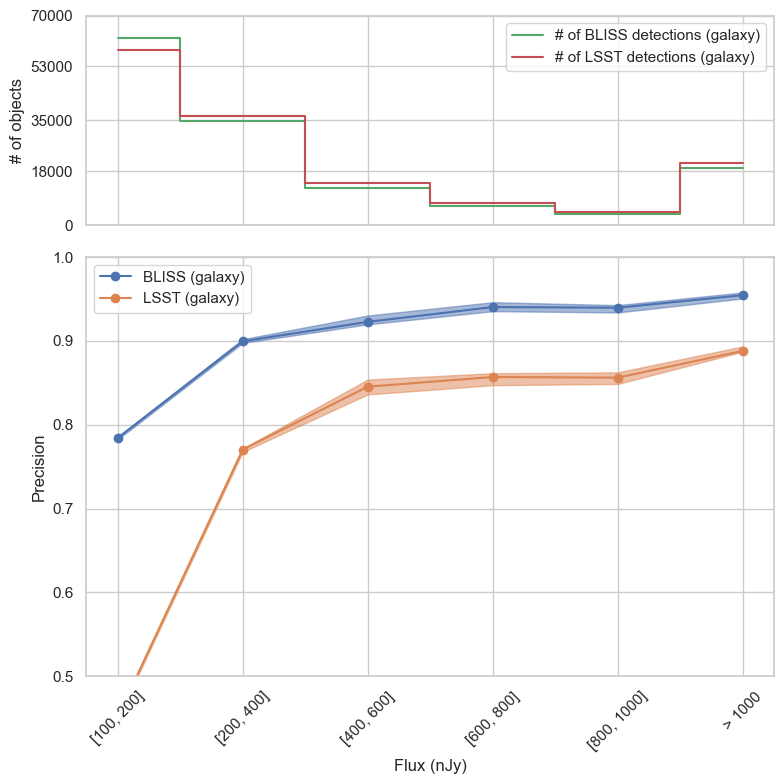

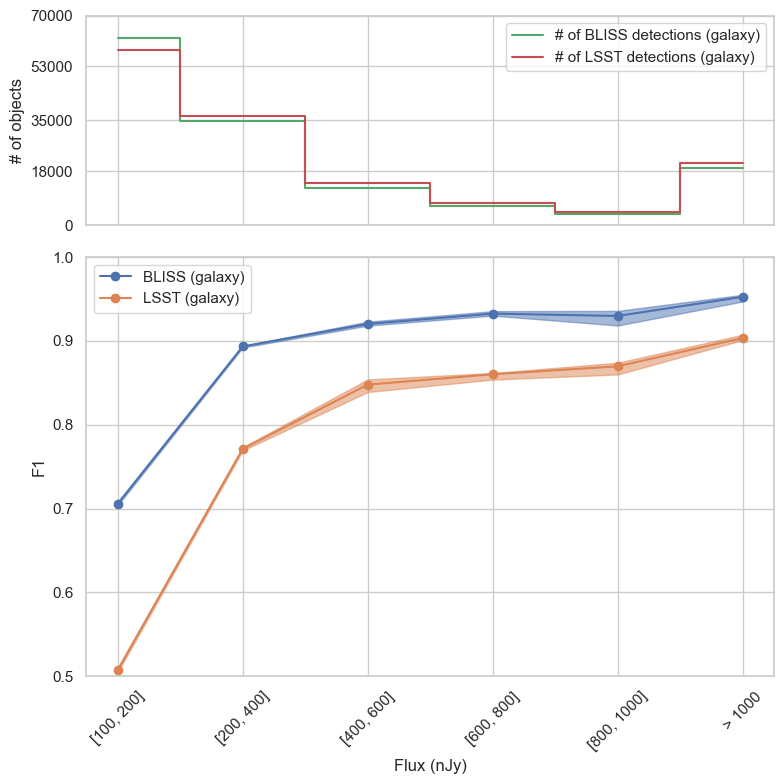

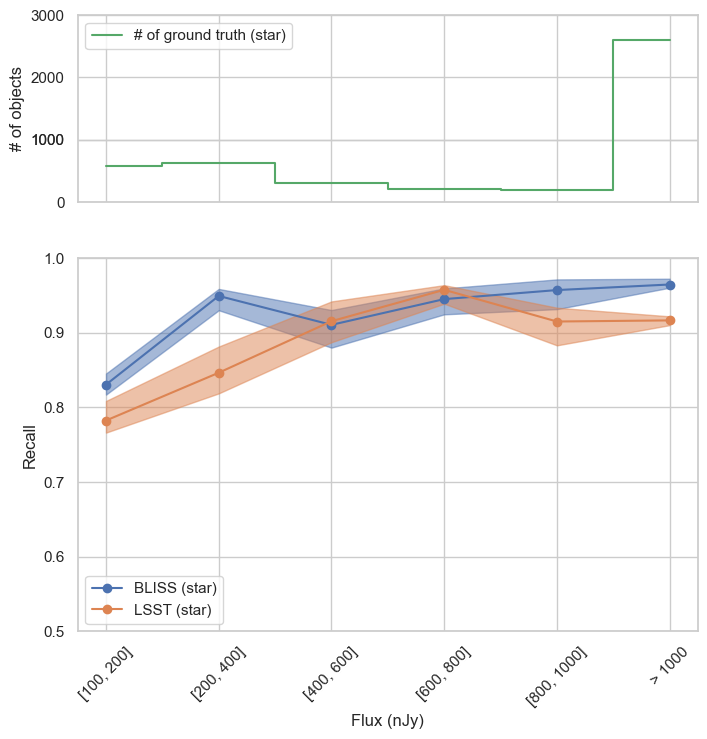

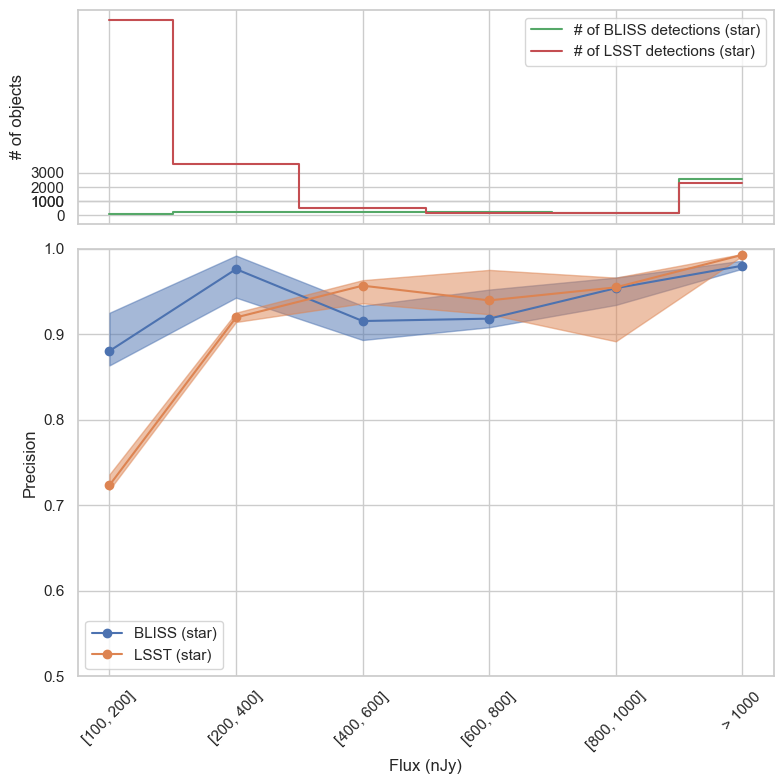

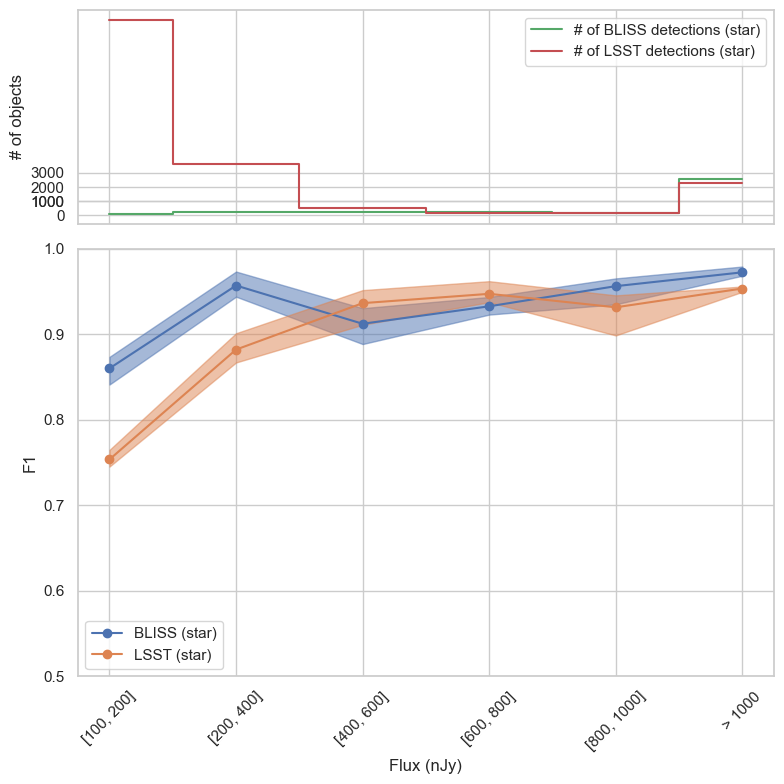

In [9]:
for k, v in bliss_metrics.items():
    bin_cutoffs = v.bin_cutoffs
    postfix_str = v.postfix_str
    recall_fig, precision_fig, f1_fig = plot_with_error_bars(
                                                    bliss_metrics_internal_states[f"n_true_sources{postfix_str}"],
                                                    bliss_metrics_internal_states[f"n_est_sources{postfix_str}"],
                                                    bliss_metrics_internal_states[f"n_true_matches{postfix_str}"],
                                                    bliss_metrics_internal_states[f"n_est_matches{postfix_str}"],
                                                    lsst_metrics_internal_states[f"n_true_sources{postfix_str}"],
                                                    lsst_metrics_internal_states[f"n_est_sources{postfix_str}"],
                                                    lsst_metrics_internal_states[f"n_true_matches{postfix_str}"],
                                                    lsst_metrics_internal_states[f"n_est_matches{postfix_str}"],
                                                    bin_cutoffs=bin_cutoffs,
                                                    postfix_str=postfix_str,
                                                    model_name_1="BLISS",
                                                    model_name_2="LSST")
    
    recall_fig.savefig(output_dir / f"recall{postfix_str}.pdf", bbox_inches="tight", dpi=NoteBookVariables.dpi)
    recall_fig.show()
    precision_fig.savefig(output_dir / f"precision{postfix_str}.pdf", bbox_inches="tight", dpi=NoteBookVariables.dpi)
    precision_fig.show()
    f1_fig.savefig(output_dir / f"f1{postfix_str}.pdf", bbox_inches="tight", dpi=NoteBookVariables.dpi)
    f1_fig.show()